In [129]:
# Author: Marc Padrós Jiménez
# Bachelor's Final Degree Project
# Date: 21st April 2022

from fastai.vision.all import *
import cv2
import numpy as np

import sys
sys.path.append("..")
from Grid_algorithm.grid_bboxes_library import *

import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [130]:
# Get the path of the test images
path = "../Grid_algorithm/Test_images/"

Detect the lungs of a test image

In [131]:
imageName = input("Enter the name of the image: ")
imagePath = path + imageName + ".png"
bboxes = get_bboxes(path, Path(imagePath)) # bboxes is a 2x4 numpy array 

Get the grids related to pleural effusion

True

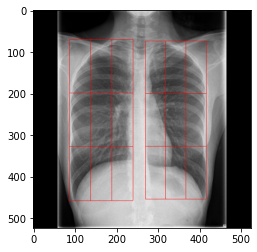

<Figure size 432x288 with 0 Axes>

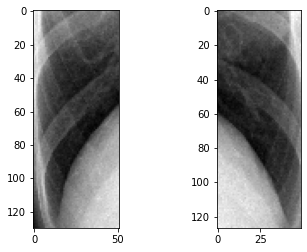

In [132]:
gridsLungLeft = np.zeros(3 * 3, object) 
gridsLungRight = np.zeros(3 * 3, object) 

imgRes = cv2.imread(imagePath)

# NOTE: I read again the BW image that was previously readen because 
# I need it as an array, not as a PILImage type to be able to access the pixels values 
imgOri = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE) 

gridBbox(bboxes[0], imgRes, imgOri, gridsLungLeft, 3, 3) # grid bbox left
gridBbox(bboxes[1], imgRes, imgOri, gridsLungRight, 3, 3) # grid bbox right

plt.imshow(imgRes)

plt.figure()

f, axarr = plt.subplots(1,2) 

pleuralEffusionPath = path + 'pleural_effusion_detection/'

gridsImagePath = pleuralEffusionPath + imageName + '/'

os.makedirs(gridsImagePath, exist_ok=True)

axarr[0].imshow(gridsLungLeft[6])
cv2.imwrite(os.path.join(gridsImagePath,'D3_{}.png'.format(imageName)), gridsLungLeft[6])

axarr[1].imshow(gridsLungRight[8])
cv2.imwrite(os.path.join(gridsImagePath,'E3_{}.png'.format(imageName)), gridsLungRight[8])


Classify grids as normal or pleural effusion

In [133]:
def reshape(grid):
  x = grid.reshape((1, 20, 20, 1))
  return x

In [134]:
def img_to_numpy_array(img_object):
    im_width = 40
    im_height = 40
    img = load_img(img_object, grayscale=True)
    img.thumbnail((im_width, im_height)) # scale the image to a size not larger than im_width x im_height
    x = img_to_array(img)  
    x = np.resize(x,(1,40, 40, 1)) # I have to call resize() instead of reshape() because img.thumbnail doesn't return a 40x40 image
    return x

In [135]:
def plot_figures(figures, n_rows, n_cols):

    fig, axes = plt.subplots(ncols = n_cols, 
                                 nrows = n_rows)
    for ind, title in enumerate(figures):
        axes.ravel()[ind].imshow(figures[title], 
                                     cmap=plt.gray())
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout()

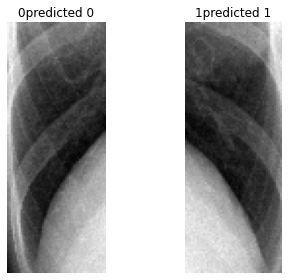

In [136]:
# Load the learned model from the Github repo: https://github.com/ashok133/Pleural-Effusion-Detection

model = keras.models.load_model("model.h5")

test_effusion_dir = gridsImagePath

total_effusion_test_images = [f for f in os.listdir(test_effusion_dir) if os.path.isfile(os.path.join(test_effusion_dir, f))]
grids = [gridsLungLeft[6], gridsLungRight[8]] 

effusion_figures_list = []
prediction_effusion = []

for i in range(len(total_effusion_test_images)):
  effusion_img_path = test_effusion_dir + total_effusion_test_images[i]
  img1 = mpimg.imread(effusion_img_path)
  #effusion_array = reshape(grids[i])
  effusion_array = img_to_numpy_array(effusion_img_path)
  prediction_effusion.append(1 if model.predict(effusion_array)[0][0] > 0.5 else 0)
  effusion_figures_list.append(img1)
  
number_of_im = 2
effusion_figures = {str(i)+'predicted '+str(prediction_effusion[i]): effusion_figures_list[i] for i in range(number_of_im)}

plot_figures(effusion_figures, 1, 2)  
